In [2]:
!pip install kora
import kora.install.rdkit

In [52]:
#importing libraries
import numpy as np
from rdkit import DataStructs
import pandas as pd

In [53]:
# auxillary function to create atom pairs
def to_numpyarray_to_list(desc):
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(desc, arr)
    return arr.tolist()

In [54]:
# function for creating descriptions
#importing libraries
from rdkit.Chem import Descriptors, Lipinski

In [55]:
def calc_descriptors(df_molecules, write=False):
    
    # Making a copy of the molecule dataframe
    df_mols_desc = df_molecules.copy()

    # Create the descriptors (9)
    df_mols_desc["molweight"] = df_mols_desc["mols"].apply(Descriptors.ExactMolWt)
    df_mols_desc["hatommolwt"] = df_mols_desc["mols"].apply(Descriptors.HeavyAtomMolWt)
    df_mols_desc["maxabspartcharge"] = df_mols_desc["mols"].apply(Descriptors.MaxAbsPartialCharge)
    df_mols_desc["maxpartcharge"] = df_mols_desc["mols"].apply(Descriptors.MaxPartialCharge)
    df_mols_desc["minabspc"] = df_mols_desc["mols"].apply(Descriptors.MinAbsPartialCharge)
    df_mols_desc["minpartcharge"] = df_mols_desc["mols"].apply(Descriptors.MinPartialCharge)
    df_mols_desc["molwt"] = df_mols_desc["mols"].apply(Descriptors.MolWt)
    df_mols_desc["numrade"] = df_mols_desc["mols"].apply(Descriptors.NumRadicalElectrons)
    df_mols_desc["numval"] = df_mols_desc["mols"].apply(Descriptors.NumValenceElectrons)

    #Lipinski (18)
    df_mols_desc["fracsp33"] = df_mols_desc["mols"].apply(Lipinski.FractionCSP3)
    df_mols_desc["heavyatomcount"] = df_mols_desc["mols"].apply(Lipinski.HeavyAtomCount)
    df_mols_desc["nhohcount"] = df_mols_desc["mols"].apply(Lipinski.NHOHCount)
    df_mols_desc["nocount"] = df_mols_desc["mols"].apply(Lipinski.NOCount)
    df_mols_desc["aliphcarbocycles"] = df_mols_desc["mols"].apply(Lipinski.NumAliphaticCarbocycles)
    df_mols_desc["aliphhetcycles"] = df_mols_desc["mols"].apply(Lipinski.NumAliphaticHeterocycles)
    df_mols_desc["aliphrings"] = df_mols_desc["mols"].apply(Lipinski.NumAliphaticRings)
    df_mols_desc["arocarbocycles"] = df_mols_desc["mols"].apply(Lipinski.NumAromaticCarbocycles)
    df_mols_desc["arohetcycles"] = df_mols_desc["mols"].apply(Lipinski.NumAromaticHeterocycles)
    df_mols_desc["arorings"] = df_mols_desc["mols"].apply(Lipinski.NumAromaticRings)
    df_mols_desc["numhacceptors"] = df_mols_desc["mols"].apply(Lipinski.NumHAcceptors)
    df_mols_desc["numhdonors"] = df_mols_desc["mols"].apply(Lipinski.NumHDonors)
    df_mols_desc["numhatoms"] = df_mols_desc["mols"].apply(Lipinski.NumHeteroatoms)
    df_mols_desc["numrotbonds"] = df_mols_desc["mols"].apply(Lipinski.NumRotatableBonds)
    df_mols_desc["numsatcarbcycles"] = df_mols_desc["mols"].apply(Lipinski.NumSaturatedCarbocycles)
    df_mols_desc["numsathetcycles"] = df_mols_desc["mols"].apply(Lipinski.NumSaturatedHeterocycles)
    df_mols_desc["numsatrings"] = df_mols_desc["mols"].apply(Lipinski.NumSaturatedRings)
    df_mols_desc["ringcount"] = df_mols_desc["mols"].apply(Lipinski.RingCount)

    #Drop SMILES and MOLS
    df_mols_desc.drop("mols", inplace=True, axis=1)


    #Fill NaN with 0
    df_mols_desc = df_mols_desc.fillna(0)
    df_mols_desc.to_csv("df_mols_desc.csv")

    return df_mols_desc

In [56]:
# creating fingerprints
# importing libraries
from rdkit.Chem import rdMolDescriptors

In [57]:
def get_morgan(molecule, length=512):
    try:
        # radius=2 = ECFP4, radius=3 = ECFP6, etc.
        desc = rdMolDescriptors.GetMorganFingerprintAsBitVect(molecule, 2, nBits=length)
    except Exception as e:
        print(e)
        print('error ' + str(molecule))
        desc = np.nan
    return desc

In [58]:
def get_maccs(molecule):
    try:
        maccs = rdMolDescriptors.GetMACCSKeysFingerprint(molecule)
        # Does not have length
    except Exception as e:
        print(e)
        print("error" + str(molecule))
        maccs = np.nan
    return maccs

In [59]:
def get_atompairs(molecule, length=512):
    try:
        atompairs = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(molecule, nBits=length)
    except Exception as e:
        print(e)
        print("error" + str(molecule))
        atompairs = np.nan
    return atompairs

In [60]:
def get_topological_torsion(molecule, length=512):
    try:
        tt = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(molecule, nBits=length)
    except Exception as e:
        print(e)
        print("error" + str(molecule))
        tt = np.nan
    return tt

In [61]:
def create_ecfp4_fingerprint(df_molecules, length=512, write=False):
    # Morgan Fingerprint (ECFP4)
    df_w = df_molecules.copy()
    df_w["ECFP4"] = df_w["mols"].apply(lambda x: get_morgan(x, length)).apply(to_numpyarray_to_list)

    # New DF with one column for each ECFP bit
    ecfp_df = df_w['ECFP4'].apply(pd.Series)
    ecfp_df = ecfp_df.rename(columns=lambda x: 'ECFP4_' + str(x + 1))

    # Write to csv
    ecfp_df.to_csv("ecfp4.csv")

    return ecfp_df

In [62]:
def create_maccs_fingerprint(df_molecules, write=False):
    # MACCS keys
    df_w = df_molecules.copy()
    df_w["MACCS"] = df_w["mols"].apply(get_maccs).apply(to_numpyarray_to_list)

    # New DF with one column for each MACCS key
    maccs_df = df_w['MACCS'].apply(pd.Series)
    maccs_df = maccs_df.rename(columns=lambda x: 'MACCS_' + str(x + 1))

    # Write to csv
    maccs_df.to_csv("maccs.csv")

    return maccs_df

In [63]:
def create_atompairs_fingerprint(df_molecules, length=512, write=False):
    # ATOM PAIRS
    df_w = df_molecules.copy()
    df_w["ATOMPAIRS"] = df_w["mols"].apply(lambda x: get_atompairs(x, length)).apply(
        to_numpyarray_to_list)

    # New DF with one column for each ATOM PAIRS key
    atom_pairs_df = df_w['ATOMPAIRS'].apply(pd.Series)
    atom_pairs_df = atom_pairs_df.rename(columns=lambda x: 'ATOMPAIR_' + str(x + 1))

    # Write to csv
    atom_pairs_df.to_csv("atom_pairs.csv")

    return atom_pairs_df

In [64]:
def create_topological_torsion_fingerprint(df_molecules, length=512, write=False):
    
    # Topological Torsion
    df_w = df_molecules.copy()
    df_w["TT"] = df_w["mols"].apply(lambda x: get_topological_torsion(x, length)).apply(to_numpyarray_to_list)

    # New DF with one column for each Topological torsion key
    tt_df = df_w['TT'].apply(pd.Series)
    tt_df = tt_df.rename(columns=lambda x: 'TT' + str(x + 1))

    # Write to csv
    tt_df.to_csv("topological_torsion.csv")

    return tt_df

In [ ]:
# pip install matplotlib

In [ ]:
# pip install tqdm

In [65]:
# plotting libraries
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [ ]:
# pip install sklearn

In [ ]:
# pip install xgboost

In [66]:
# Models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb

In [ ]:
# pip install imblearn

In [ ]:
# pip install requests

In [67]:
# Misc
from rdkit import Chem
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, \
    roc_auc_score, precision_recall_curve, average_precision_score
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTENC
from collections import Counter
import re, requests

In [88]:
def create_original_df(usedf=False, file=None, write_s=False, write_off=False):
    
    # Create dataframe from csv
    if not usedf:
        df = pd.read_csv("C:/Users/SENJUTI GHOSH/Technocolabs_PredictingAdverseReactions/datasets/sider.csv", skipinitialspace=True)
    else:
        df = file.copy()

    # Extract SMILES column
    df_molecules = pd.DataFrame(df["smiles"])

    # Converting to molecules
    df_molecules["mols"] = df_molecules["smiles"].apply(Chem.MolFromSmiles)

    # Droping mols and smiles
    df_y = df.drop("smiles", axis=1)

    # Write to csv
    df_molecules.to_csv("df_molecules.csv")
    df_y.to_csv("df_y.csv")

    df_molecules.to_csv("df_off_mols.csv")
    df_y.to_csv("df_off_y.csv")

    return df_y, df_molecules

In [89]:
def createfingerprints(df_mols, length): # using fingerprints functions
    
    # Morgan Fingerprint (ECFP4)
    ecfp_df = create_ecfp4_fingerprint(df_mols, length, False)

    # MACCS keys (always 167)
    maccs_df = create_maccs_fingerprint(df_mols, False)

    # ATOM PAIRS
    atom_pairs_df = create_atompairs_fingerprint(df_mols, length, False)

    # Topological torsion
    tt_df = create_topological_torsion_fingerprint(df_mols, length, False)

    return ecfp_df, maccs_df, atom_pairs_df, tt_df

In [90]:
def createdescriptors(df_molecules): # using descriptions function
    
    # Descriptors
    df_mols_desc = calc_descriptors(df_molecules, False)

    return df_mols_desc

In [91]:
def test_fingerprint_size(df_mols, df_y, model, colname="Hepatobiliary disorders", num_sizes_to_test=20, min_size=100,
                          max_size=2048, cv=10, makeplots=False, write=False):
    
    # Fingerprint length type and selection
    # Scoring metrics to use
    scoring_metrics = ("f1_micro", "f1_macro", "f1", "roc_auc", "recall", "precision", "average_precision")
    sizes = np.linspace(min_size, max_size, num_sizes_to_test, dtype=int)

    # Create results dataframes for each metric
    results_f1 = np.zeros([4, len(sizes)])
    results_rocauc = np.zeros([4, len(sizes)])
    results_precision = np.zeros([4, len(sizes)])
    results_recall = np.zeros([4, len(sizes)])
    results_average_precision = np.zeros([4, len(sizes)])
    results_f1_micro = np.zeros([4, len(sizes)])
    results_f1_macro = np.zeros([4, len(sizes)])

    # Get test sizes
    c = 0
    
    # Size testing using SVC with scale gamma (1 / (n_features * X.var()))
    for s in tqdm(sizes):
        
        # Create fingerprint with size S
        fingerprints = createfingerprints(df_mols, int(s))
        r = 0
        for fp in fingerprints:
            X = fp.copy()
            
            # Using "Hepatobiliary disorders" as an results example since its balanced
            y = df_y[colname].copy()
            
            # 10-fold cross validation
            cv_scores = cross_validate(model, X, y, cv=cv, scoring=scoring_metrics, return_train_score=False, n_jobs=-1)

            for k, v in cv_scores.items():
                if k == "test_roc_auc":
                    results_rocauc[r, c] = v.mean()
                if k == "test_precision":
                    results_precision[r, c] = v.mean()
                if k == "test_recall":
                    results_recall[r, c] = v.mean()
                if k == "test_average_precision":
                    results_average_precision[r, c] = v.mean()
                if k == "test_f1":
                    results_f1[r, c] = v.mean()
                if k == "test_f1_micro":
                    results_f1_micro[r, c] = v.mean()
                if k == "test_f1_macro":
                    results_f1_macro[r, c] = v.mean()
            r += 1
        c += 1

    all_results = (results_rocauc, results_precision, results_recall, results_average_precision, results_f1,
                   results_f1_micro, results_f1_macro)

    # Create dataframe for results
    df_results_rocauc_size_SVC = pd.DataFrame(results_rocauc, columns=sizes)
    df_results_precision_size_SVC = pd.DataFrame(results_precision, columns=sizes)
    df_results_recall_size_SVC = pd.DataFrame(results_recall, columns=sizes)
    df_results_av_prec_size_SVC = pd.DataFrame(results_average_precision, columns=sizes)
    df_results_f1_size_SVC = pd.DataFrame(results_f1, columns=sizes)
    df_results_f1_micro_size_SVC = pd.DataFrame(results_f1_micro, columns=sizes)
    df_results_f1_macro_size_SVC = pd.DataFrame(results_f1_macro, columns=sizes)

    all_df_results = (
        df_results_rocauc_size_SVC, df_results_precision_size_SVC, df_results_recall_size_SVC,
        df_results_av_prec_size_SVC, df_results_f1_size_SVC, df_results_f1_micro_size_SVC, df_results_f1_macro_size_SVC)

    # Save to file
    df_results_rocauc_size_SVC.to_csv("df_results_rocauc_size_SVC.csv")
    df_results_precision_size_SVC.to_csv("df_results_precision_size_SVC.csv")
    df_results_recall_size_SVC.to_csv("df_results_recall_size_SVC.csv")
    df_results_av_prec_size_SVC.to_csv("df_results_av_prec_size_SVC.csv")
    df_results_f1_size_SVC.to_csv("df_results_f1_size_SVC.csv")
    df_results_f1_micro_size_SVC.to_csv("df_results_f1_micro_size_SVC.csv")
    df_results_f1_macro_size_SVC.to_csv("df_results_f1_macro_size_SVC.csv")

    if makeplots:
        fp_names = ["ECFP-4", "MACCS", "Atom Pairs", "Topological Torsion"]
        m = 0
        for d in all_results:
            fig = plt.figure(figsize=(10, 10))
            for i in range(len(fingerprints)):
                plt.plot(sizes, d[i, :], "-")
            plt.title(f"SVC, {scoring_metrics[m]} vs fingerprint length", fontsize=25)
            plt.ylabel(f"{scoring_metrics[m]}", fontsize=20)
            plt.xlabel("Fingerprint Length", fontsize=20)
            plt.legend(fp_names, fontsize=15)
            plt.ylim([0, 1])
            plt.show()
            m += 1

    return all_df_results

In [92]:
def select_best_descriptors_multi(df_desc, y_all, out_names=[], score_func=f_classif, k=1):
    
    # Select k highest scoring feature from X to every y and return new df with only the selected ones
    if not out_names:
        print("Column names necessary")
        return None
    selected = []
    for n in tqdm(out_names):
        skb = SelectKBest(score_func=score_func, k=k).fit(df_desc, y_all[n])
        n_sel_bol = skb.get_support()
        sel = df_desc.loc[:, n_sel_bol].columns.to_list()
        for s in sel:
            if s not in selected:
                selected.append(s)
    return selected

In [93]:
def select_best_descriptors(X, y, score_func=f_classif, k=2):
    
    # Select k highest scoring feature from X to y with a score function, f_classif by default
    skb = SelectKBest(score_func=score_func, k=k).fit(X, y)
    n_sel_bol = skb.get_support()
    sel = X.loc[:, n_sel_bol].columns.to_list()
    assert sel
    return sel

In [94]:
def create_dataframes_dic(df_desc_base_train, df_desc_base_test, X_train_fp, X_test_fp, y_train, out_names,
                          score_func=f_classif, k=3):
    # Create 3 dictionaries, one with the train dataframes, one with the test dataframes and one with the selected
    # features for each label

    # Initialize dictonaries
    train_series_dic = {name: None for name in out_names}
    test_series_dic = {name: None for name in out_names}
    selected_name = {name: None for name in out_names}

    # For each of the tasks build the train and test dataframe with the selected descriptors
    for name in tqdm(out_names):
        
        # Select best descriptors for the task
        sel_col = select_best_descriptors(df_desc_base_train, y_train[name], score_func=score_func, k=k)
        selected_name[name] = sel_col  # Keep track of selected columns
        df_desc_train = df_desc_base_train.loc[:, sel_col].copy()  # Get train dataframe with only selected columns
        df_desc_test = df_desc_base_test.loc[:, sel_col].copy()  # Get test dataframe with only selected columns
        X_train = pd.concat([X_train_fp, df_desc_train], axis=1)
        X_test = pd.concat([X_test_fp, df_desc_test], axis=1)
        
        # Add to the dictionary
        train_series_dic[name] = X_train
        test_series_dic[name] = X_test

    # Return the dictionaries
    return train_series_dic, test_series_dic, selected_name

In [95]:
def balance_dataset(X_train_dic, y_train_dic, out_names, random_state=0, n_jobs=-1, verbose=False):
    
    # Initialize the dictionaries and boolean array for categorical features
    train_series_dic_bal = {name: None for name in out_names}
    y_dic_bal = {name: None for name in out_names}
    cat_shape = np.full((1128,), True, dtype=bool)
    cat_shape[-3:] = False

    # For each classficiation label
    for label in tqdm(out_names):
        X_imb = X_train_dic[label]
        y_imb = y_train_dic[label]
        X_bal, y_bal = SMOTENC(categorical_features=cat_shape, random_state=random_state, n_jobs=n_jobs).fit_resample(
            X_imb, y_imb)
        train_series_dic_bal[label] = X_bal
        y_dic_bal[label] = y_bal

    # Print new counts
    if verbose:
        for label in out_names:
            print(f"For {label}")
            print(sorted(Counter(y_train_dic[label]).items()))
            print(sorted(Counter(y_dic_bal[label]).items()))

    # Return the new dictionaries
    return train_series_dic_bal, y_dic_bal

In [96]:
def grid_search(X_train, y_train, model, params_to_test, X_test=None, y_test=None, balancing=False, n_splits=5,
                scoring="f1", n_jobs=-1, verbose=False, random_state=None):
    
    # Define grid search
    if balancing:
        
        # Save index of categorical features
        cat_shape = np.full((1128,), True, dtype=bool)
        cat_shape[-3:] = False
        
        # Prepatre SMOTENC
        smotenc = SMOTENC(categorical_features=cat_shape, random_state=random_state, n_jobs=n_jobs)
        
        # Make a pipeline with the balancing and the estimator, balacing is only called when fitting
        pipeline = make_pipeline(smotenc, model)
        
        # Determine stratified k folds
        kf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
        
        # Call cross validate
        grid_search = GridSearchCV(pipeline, params_to_test, cv=kf, n_jobs=n_jobs, verbose=verbose, scoring=scoring)

    else:
        kf = StratifiedKFold(n_splits=n_splits, random_state=random_state)
        grid_search = GridSearchCV(model, params_to_test, cv=kf, n_jobs=n_jobs, verbose=verbose, scoring=scoring)

    # Fit X and y to test parameters
    grid_search.fit(X_train, y_train)
    means = grid_search.cv_results_["mean_test_score"]
    stds = grid_search.cv_results_["std_test_score"]

    if verbose:
        
        # Print scores
        print()
        print("Score for development set:")
        for mean, std, params in zip(means, stds, grid_search.cv_results_["params"]):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 1.96, params))
        print()

        # Print best parameters
        print()
        print("Best parameters set found:")
        print(grid_search.best_params_)
        print()
        if X_test and y_test:
            
            # Detailed Classification report
            print()
            print("Detailed classification report:")
            print("The model is trained on the full development set.")
            print("The scores are computed on the full evaluation set.")
            print()
            y_true, y_pred = y_test, grid_search.predict(X_test)
            print(classification_report(y_true, y_pred))
            print()
            print("Confusion Matrix as")
            print("""
            TN FP
            FN TP
            """)
            print(confusion_matrix(y_true, y_pred))
    
    # Save best estimator
    best_estimator = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # And return it
    return best_params, best_estimator

In [97]:
def multi_label_grid_search(X_train_dic, y_train, out_names, model, params_to_test, balancing=False, X_test=None,
                            y_test=None, n_splits=5, scoring="f1", n_jobs=-1, verbose=False, random_state=None):
    
    # Creates a dictionary with the best params in regards to chosen metric for each label

    # Creates the dictionary
    best_params_by_label = {label: None for label in out_names}

    # If X_test and y_test is given so that generalization evalutation can happen
    if X_test and y_test:
        for label in tqdm(out_names):
            print()
            print(f"Scores for {label}")
            best_params, _ = grid_search(X_train_dic[label], y_train[label], model, params_to_test[label],
                                         X_test[label], y_test[label], n_splits=n_splits, scoring=scoring,
                                         verbose=verbose, n_jobs=n_jobs, balancing=balancing, random_state=random_state)
            best_params_by_label[label] = best_params
    else:
        for label in tqdm(out_names):
            print()
            print(f"Scores for {label}")
            best_params, _ = grid_search(X_train_dic[label], y_train[label], model, params_to_test[label],
                                         n_splits=n_splits, scoring=scoring, verbose=verbose, n_jobs=n_jobs,
                                         balancing=balancing, random_state=random_state)
            best_params_by_label[label] = best_params

    return best_params_by_label

In [98]:
def random_search(X_train, y_train, model, params_to_test, X_test=None, y_test=None, balancing=False,
                  n_iter=100, n_splits=5, scoring="f1", n_jobs=-1, verbose=False, random_state=None):
    
    # Define random search
    if balancing:
        
        # Save index of categorical features
        cat_shape = np.full((1128,), True, dtype=bool)
        cat_shape[-3:] = False
        
        # Prepatre SMOTENC
        smotenc = SMOTENC(categorical_features=cat_shape, random_state=random_state, n_jobs=n_jobs)
        
        # Make a pipeline with the balancing and the estimator, balacing is only called when fitting
        pipeline = make_pipeline(smotenc, model)
        
        # Determine stratified k folds
        kf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
        
        # Call cross validate
        rs = RandomizedSearchCV(pipeline, params_to_test, n_iter=n_iter, cv=kf, n_jobs=n_jobs, verbose=verbose,
                                scoring=scoring)

    else:
        kf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
        rs = RandomizedSearchCV(model, params_to_test, n_iter=n_iter, cv=kf, n_jobs=n_jobs, verbose=verbose,
                                scoring=scoring)

    # Fit parameters
    rs.fit(np.asarray(X_train), np.asarray(y_train))
    means = rs.cv_results_["mean_test_score"]
    stds = rs.cv_results_["std_test_score"]

    # Print scores
    if verbose:
        print()
        print("Score for development set:")

        for mean, std, params in zip(means, stds, rs.cv_results_["params"]):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 1.96, params))
        print()

        # Print best parameters
        print()
        print("Best parameters set found:")
        print(rs.best_params_)
        print()
        if X_test and y_test:
            
            # Detailed Classification report

            print()
            print("Detailed classification report:")
            print("The model is trained on the full development set.")
            print("The scores are computed on the full evaluation set.")
            print()
            y_true, y_pred = y_test, rs.predict(X_test)
            print(classification_report(y_true, y_pred))
            print()
            """
            print("Confusion matrix as:")
            print(
                   TN FP
                   FN TP
                   )
            print(confusion_matrix(y_true, y_pred))
            print()
            """
    # Save best estimator
    best_estimator = rs.best_estimator_
    best_params = rs.best_params_
    
    # And return it
    return best_params, best_estimator

In [99]:
def multi_label_random_search(X_train_dic, y_train, out_names, model, params_to_test, balancing=False, X_test=None,
                              y_test=None, n_iter=100, n_splits=5, scoring="f1", n_jobs=-1, verbose=False,
                              random_state=None):
    # Creates a dictionary with the best params in regards to chosen metric for each label

    # Creates the dictionary
    best_params_by_label = {label: None for label in out_names}

    # If X_test and y_test is given so that generalization evalutation can happen
    if X_test and y_test:
        for label in tqdm(out_names):
            print()
            print(f"Scores for {label}")
            best_params, _ = random_search(X_train_dic[label], y_train[label], model, params_to_test[label],
                                           X_test[label], y_test[label], n_iter=n_iter, n_splits=n_splits,
                                           scoring=scoring, verbose=verbose, n_jobs=n_jobs, random_state=random_state,
                                           balancing=balancing)
            best_params_by_label[label] = best_params
    else:
        for label in tqdm(out_names):
            print()
            print(f"Scores for {label}")
            best_params, _ = random_search(X_train_dic[label], y_train[label], model, params_to_test[label],
                                           n_iter=n_iter, n_splits=n_splits, scoring=scoring, verbose=verbose,
                                           n_jobs=n_jobs, random_state=random_state, balancing=balancing)
            best_params_by_label[label] = best_params

    return best_params_by_label

In [100]:
def score_report(estimator, X_test, y_test, verbose=False, plot=False, name=None):
    
    # Predicting value
    y_true, y_pred = y_test, estimator.predict(X_test)
    y_score = estimator.predict_proba(X_test)
    y_score = y_score[:, 1]

    # Individual metrics
    f1_micr_score = f1_score(y_true, y_pred, average="micro")
    f1_macro_score = f1_score(y_true, y_pred, average="macro")
    f1_s_score = f1_score(y_true, y_pred, average="binary")
    auc = roc_auc_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred, average="binary")
    prec = precision_score(y_true, y_pred, average="binary")
    average_precision = average_precision_score(y_true, y_score)

    # Detailed Classification report
    if verbose:
        print()
        print("The scores are computed on the full evaluation set")
        print("These are not used to train or optimize the model")
        print()
        print("Detailed classification report:")
        print(classification_report(y_true, y_pred))
        print()

        print("Confusion matrix as:")
        print("""
               TN FP
               FN TP
               """)
        print(confusion_matrix(y_true, y_pred))
        print()

        print("Individual metrics:")
        print(f"F1 Micro score: {f1_micr_score:.3f}")
        print(f"F1 Macro score: {f1_macro_score:.3f}")
        print(f"F1 Binary score: {f1_s_score:.3f}")
        print(f"AUROC score: {auc:.3f}")
        print(f"Recall score: {rec:.3f}")
        print(f"Precision score: {prec:.3f}")
        print(f"Average precision-recall score: {average_precision:.3f}")
        print()

    if plot:
        precision, recall, _ = precision_recall_curve(y_true, y_score)

        # step_kwargs = ({'step': 'post'}
        #                if 'step' in signature(plt.fill_between).parameters
        #                else {})

        plt.step(recall, precision, color="r", alpha=0.2, where="post")
        plt.fill_between(recall, precision, step="post", alpha=0.2, color="#F59B00")

        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title(f'{name} \n Precision-Recall curve: AP={average_precision:0.2f}')

        plt.savefig(f"Precision-Recall curve.png")
        plt.clf()


    return {"f1_micr_score": f1_micr_score, "auc_score": auc, "rec_score": rec, "prec_score": prec,
            "f1_macro_score": f1_macro_score, "f1_s_score": f1_s_score, "prec_rec_score": average_precision}

In [101]:
def cv_report(estimator, X_train, y_train, balancing=False, n_splits=5,
              scoring_metrics=("f1_micro", "f1_macro", "f1", "roc_auc", "recall", "precision", "average_precision"),
              random_state=None, n_jobs=-1, verbose=False):
    if balancing:
        
        # Save index of categorical features
        cat_shape = np.full((1128,), True, dtype=bool)
        cat_shape[-3:] = False
        
        # Prepare SMOTENC
        smotenc = SMOTENC(categorical_features=cat_shape, random_state=random_state, n_jobs=n_jobs)
        
        # Make a pipeline with the balancing and the estimator, balacing is only called when fitting
        pipeline = make_pipeline(smotenc, estimator)
        
        # Determine stratified k folds
        kf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
        
        # Call cross validate
        scores = cross_validate(pipeline, np.asarray(X_train), np.asarray(y_train), scoring=scoring_metrics, cv=kf,
                                n_jobs=n_jobs, verbose=verbose, return_train_score=False)

    else:
        # Normal cross validation
        kf = StratifiedKFold(n_splits=n_splits, random_state=random_state,shuffle=True)
        scores = cross_validate(estimator, np.asarray(X_train), np.asarray(y_train), scoring=scoring_metrics, cv=kf,
                                n_jobs=n_jobs, verbose=verbose, return_train_score=False)

    # Means
    f1_s = np.mean(scores["test_f1_micro"])
    f1_ms = np.mean(scores["test_f1_macro"])
    f1_bs = np.mean(scores["test_f1"])
    auc_s = np.mean(scores["test_roc_auc"])
    rec_s = np.mean(scores["test_recall"])
    prec_s = np.mean(scores["test_precision"])
    avp_s = np.mean(scores["test_average_precision"])

    # STD
    f1_std = np.std(scores["test_f1_micro"])
    f1_mstd = np.std(scores["test_f1_macro"])
    f1_bstd = np.std(scores["test_f1"])
    auc_std = np.std(scores["test_roc_auc"])
    rec_std = np.std(scores["test_recall"])
    prec_std = np.std(scores["test_precision"])
    avp_std = np.std(scores["test_average_precision"])

    if verbose:
        print()
        print("Individual metrics")
        print(f"F1 Micro Score: Mean: {f1_s:.3f} (Std: {f1_std:.3f})")
        print(f"F1 Macro Score: Mean: {f1_ms:.3f} (Std: {f1_mstd:.3f})")
        print(f"F1 Binary Score: Mean: {f1_bs:.3f} (Std: {f1_bstd:.3f})")
        print(f"AUROC score: Mean: {auc_s:.3f} (Std: {auc_std:.3f})")
        print(f"Recall score: Mean: {rec_s:.3f} (Std: {rec_std:.3f})")
        print(f"Precision score: Mean: {prec_s:.3f} (Std: {prec_std:.3f})")
        print(f"Average Precision score: Mean: {avp_s:.3f} (Std: {avp_std:.3f})")
        print()

    return {"f1_micr_score": f1_s, "f1_micr_std": f1_std, "auc_score": auc_s, "auc_std": auc_std, "rec_score": rec_s,
            "rec_std": rec_std, "prec_score": prec_s, "prec_std": prec_std, "f1_macro_score": f1_ms,
            "f1_macro_std": f1_mstd, "f1_score": f1_bs, "f1_std": f1_bstd, "avp_score": avp_s, "avp_std": avp_std}

In [102]:
def cv_multi_report(X_train_dic, y_train, out_names, model=None, balancing=False, modelname=None, spec_params=None,
                    random_state=None, n_splits=5, n_jobs=-1, verbose=False):
    
    # Creates a scores report dataframe for each classification label with cv
    # Initizalize the dataframe
    report = pd.DataFrame(
        columns=["F1 Binary", "F1 Micro", "F1 Macro", "ROC_AUC", "Recall", "Precision", "Average Precision"],
        index=out_names)
    scoring_metrics = ("f1_micro", "f1_macro", "f1", "roc_auc", "recall", "precision", "average_precision")

    # For each label
    for name in tqdm(out_names):
        if verbose:
            print()
            print(f"Scores for {name}")
        
        # Calculate the score for the current label using the respective dataframe
        if spec_params:
            
            # Define the specific parameters for each model for each label
            if modelname[name] == "SVC":
                model_temp = SVC(random_state=random_state, probability=True)
                model_temp.set_params(C=spec_params[name]["svc__C"],
                                      gamma=spec_params[name]["svc__gamma"],
                                      kernel=spec_params[name]["svc__kernel"])
            elif modelname[name] == "RF":
                model_temp = RandomForestClassifier(n_estimators=100, random_state=random_state)
                model_temp.set_params(bootstrap=spec_params[name]["randomforestclassifier__bootstrap"],
                                      max_depth=spec_params[name]["randomforestclassifier__max_depth"],
                                      max_features=spec_params[name]["randomforestclassifier__max_features"],
                                      min_samples_leaf=spec_params[name]["randomforestclassifier__min_samples_leaf"],
                                      min_samples_split=spec_params[name]["randomforestclassifier__min_samples_split"],
                                      n_estimators=spec_params[name]["randomforestclassifier__n_estimators"])
            elif modelname[name] == "XGB":
                model_temp = xgb.XGBClassifier(objective="binary:logistic", random_state=random_state)
                model_temp.set_params(colsample_bytree=spec_params[name]["xgbclassifier__colsample_bytree"],
                                      eta=spec_params[name]["xgbclassifier__eta"],
                                      gamma=spec_params[name]["xgbclassifier__gamma"],
                                      max_depth=spec_params[name]["xgbclassifier__max_depth"],
                                      min_child_weight=spec_params[name]["xgbclassifier__min_child_weight"],
                                      subsample=spec_params[name]["xgbclassifier__subsample"])
            elif modelname[name] == "VotingClassifier":
                
                # Spec params must be the list of the dictionaries with the params in order (SVC - RF - XGB)
                model_svc = SVC(random_state=random_state, probability=True)
                model_rf = RandomForestClassifier(n_estimators=100, random_state=random_state)
                model_xgb = xgb.XGBClassifier(objective="binary:logistic", random_state=random_state)

                model_svc.set_params(C=spec_params[0][name]["svc__C"],
                                     gamma=spec_params[0][name]["svc__gamma"],
                                     kernel=spec_params[0][name]["svc__kernel"])
                model_rf.set_params(bootstrap=spec_params[1][name]["randomforestclassifier__bootstrap"],
                                    max_depth=spec_params[1][name]["randomforestclassifier__max_depth"],
                                    max_features=spec_params[1][name]["randomforestclassifier__max_features"],
                                    min_samples_leaf=spec_params[1][name]["randomforestclassifier__min_samples_leaf"],
                                    min_samples_split=spec_params[1][name]["randomforestclassifier__min_samples_split"],
                                    n_estimators=spec_params[1][name]["randomforestclassifier__n_estimators"])
                model_xgb.set_params(colsample_bytree=spec_params[2][name]["xgbclassifier__colsample_bytree"],
                                     eta=spec_params[2][name]["xgbclassifier__eta"],
                                     gamma=spec_params[2][name]["xgbclassifier__gamma"],
                                     max_depth=spec_params[2][name]["xgbclassifier__max_depth"],
                                     min_child_weight=spec_params[2][name]["xgbclassifier__min_child_weight"],
                                     subsample=spec_params[2][name]["xgbclassifier__subsample"])

                model_temp = VotingClassifier(estimators=[("svc", model_svc), ("rf", model_rf), ("xgb", model_xgb)],
                                              voting="soft", n_jobs=n_jobs)

            else:
                print("Please specify used model (SVC, RF, XGB)")
                return None
            scores = cv_report(model_temp, X_train_dic[name], y_train[name], balancing=balancing, n_splits=n_splits,
                               scoring_metrics=scoring_metrics, n_jobs=n_jobs, verbose=verbose,
                               random_state=random_state)
        else:
            scores = cv_report(model, X_train_dic[name], y_train[name], balancing=balancing, n_splits=n_splits,
                               scoring_metrics=scoring_metrics, n_jobs=n_jobs, verbose=verbose,
                               random_state=random_state)
        report.loc[name, "F1 Micro"] = round(float(scores["f1_micr_score"]), 3)
        report.loc[name, "F1 Macro"] = round(float(scores["f1_macro_score"]), 3)
        report.loc[name, "F1 Binary"] = round(float(scores["f1_score"]), 3)
        report.loc[name, "ROC_AUC"] = round(float(scores["auc_score"]), 3)
        report.loc[name, "Recall"] = round(float(scores["rec_score"]), 3)
        report.loc[name, "Precision"] = round(float(scores["prec_score"]), 3)
        report.loc[name, "Average Precision"] = round(float(scores["avp_score"]), 3)
    report = report.apply(pd.to_numeric)
    return report

In [103]:
def test_score_multi_report(X_train_dic, y_train, X_test, y_test, out_names, model=None, modelname=None,
                            spec_params=None, balancing=False, random_state=None, plot=False, verbose=False, n_jobs=-1):
    
    # Creates a scores report dataframe for each classification label with cv
    # Initizalize the dataframe
    report = pd.DataFrame(columns=["F1 Binary", "F1 Micro", "F1 Macro", "ROC_AUC", "Recall", "Precision"],
                          index=out_names)

    # For each label
    for name in tqdm(out_names):
        if verbose:
            print()
            print(f"Scores for {name}")
        
        # Calculate the score for the current label using the respective dataframe
        if spec_params:
            
            # Define the specific parameters for each model for each label
            if modelname[name] == "SVC":
                model_temp = SVC(random_state=random_state, probability=True)
                model_temp.set_params(C=spec_params[name]["svc__C"],
                                      gamma=spec_params[name]["svc__gamma"],
                                      kernel=spec_params[name]["svc__kernel"])
            elif modelname[name] == "RF":
                model_temp = RandomForestClassifier(n_estimators=100, random_state=random_state)
                model_temp.set_params(bootstrap=spec_params[name]["randomforestclassifier__bootstrap"],
                                      max_depth=spec_params[name]["randomforestclassifier__max_depth"],
                                      max_features=spec_params[name]["randomforestclassifier__max_features"],
                                      min_samples_leaf=spec_params[name]["randomforestclassifier__min_samples_leaf"],
                                      min_samples_split=spec_params[name]["randomforestclassifier__min_samples_split"],
                                      n_estimators=spec_params[name]["randomforestclassifier__n_estimators"])
            elif modelname[name] == "XGB":
                model_temp = xgb.XGBClassifier(objective="binary:logistic", random_state=random_state)
                model_temp.set_params(colsample_bytree=spec_params[name]["xgbclassifier__colsample_bytree"],
                                      eta=spec_params[name]["xgbclassifier__eta"],
                                      gamma=spec_params[name]["xgbclassifier__gamma"],
                                      max_depth=spec_params[name]["xgbclassifier__max_depth"],
                                      min_child_weight=spec_params[name]["xgbclassifier__min_child_weight"],
                                      subsample=spec_params[name]["xgbclassifier__subsample"])
            else:
                print("Please specify used model (SVC, RF, XGB)")
                return None

            if balancing:
                
                # Save index of categorical features
                cat_shape = np.full((1128,), True, dtype=bool)
                cat_shape[-3:] = False
                
                # Prepatre SMOTENC
                smotenc = SMOTENC(categorical_features=cat_shape, random_state=random_state, n_jobs=n_jobs)
                
                # Make a pipeline with the balancing and the estimator, balacing is only called when fitting
                pipeline = make_pipeline(smotenc, model_temp)
                
                # Fit and test
                pipeline.fit(np.asarray(X_train_dic[name]), np.asarray(y_train[name]))
                scores = score_report(pipeline, np.asarray(X_test[name]), np.asarray(y_test[name]), plot=plot,
                                      verbose=verbose, name=name)

            else:
                model_temp.fit(np.asarray(X_train_dic[name]), np.asarray(y_train[name]))
                scores = score_report(model_temp, np.asarray(X_test[name]), np.asarray(y_test[name]), plot=plot,
                                      verbose=verbose, name=name)

        else:
            if balancing:
                
                # Save index of categorical features
                cat_shape = np.full((1128,), True, dtype=bool)
                cat_shape[-3:] = False
                
                # Prepatre SMOTENC
                smotenc = SMOTENC(categorical_features=cat_shape, random_state=random_state, n_jobs=n_jobs)

                # Make a pipeline with the balancing and the estimator, balacing is only called when fitting
                pipeline = make_pipeline(smotenc, model)
                
                # Fit and test
                pipeline.fit(np.asarray(X_train_dic[name]), np.asarray(y_train[name]))
                scores = score_report(pipeline, np.asarray(X_test[name]), np.asarray(y_test[name]), plot=plot,
                                      verbose=verbose, name=name)

            else:
                model.fit(np.asarray(X_train_dic[name]), np.asarray(y_train[name]))
                scores = score_report(model, np.asarray(X_test[name]), np.asarray(y_test[name]), plot=plot,
                                      verbose=verbose, name=name)

        report.loc[name, "F1 Micro"] = round(float(scores["f1_micr_score"]), 3)
        report.loc[name, "F1 Macro"] = round(float(scores["f1_macro_score"]), 3)
        report.loc[name, "F1 Binary"] = round(float(scores["f1_s_score"]), 3)
        report.loc[name, "ROC_AUC"] = round(float(scores["auc_score"]), 3)
        report.loc[name, "Recall"] = round(float(scores["rec_score"]), 3)
        report.loc[name, "Precision"] = round(float(scores["prec_score"]), 3)
        report.loc[name, "Average Prec-Rec"] = round(float(scores["prec_rec_score"]), 3)
        
        # prec_rec_score
    report = report.apply(pd.to_numeric)
    return report

In [104]:
def get_smile_from_cid(cid):
    # Trim CID
    ct = re.sub("^CID[0]*", "", cid)

    # Getting smile
    res = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{ct}/property/CanonicalSMILES/txt")

    # Checking for Error 400
    try:
        res.raise_for_status()
    except Exception as e:
        print(f"Problem retrieving smile for {cid}: {e}")

    # If everything is ok, get smile text
    res_t = res.text.strip("\n")

    # Return smile
    return res_t

In [105]:
def create_offside_df(out_names, write=False):
    oss = pd.read_csv("offsides_socs.csv")
    oss_df = oss[["stitch_id", "SOC"]].copy()

    stitchs = oss_df.stitch_id.unique()
    sti_to_smil = {stitch: get_smile_from_cid(stitch) for stitch in tqdm(stitchs)}

    d = {"stitch_id": stitchs}
    mod_off = pd.DataFrame(data=d)

    mod_off["smiles"] = mod_off.stitch_id.apply(lambda x: sti_to_smil[x])

    for name in out_names:
        mod_off[name] = 0

    for index, row in tqdm(oss_df.iterrows()):
        if row["SOC"] in out_names:
            mod_off.loc[mod_off["stitch_id"] == row["stitch_id"], row["SOC"]] = 1

    mod_off.drop("stitch_id", inplace=True, axis=1)
    mod_off.to_csv("offside_socs_modified.csv", index=False)

    return mod_off

In [106]:
# Importing libraries for modelling
from sklearn.model_selection import train_test_split
from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

# Functions
from params_by_label import *

# Fixing the seed
seed = 6
np.random.seed(seed)

In [107]:
# model development

# Creating base df_molecules, df_y with the results vectors, and df_mols_descr with the descriptors
print("Creating Dataframes")
y_all, df_molecules = create_original_df(write_s=False)
df_molecules.drop("smiles", axis=1, inplace=True)
todrop = ["Product issues", "Investigations", "Social circumstances"]
y_all.drop(todrop, axis=1, inplace=True)  # No real connection with the molecule, multiple problems
out_names = y_all.columns.tolist()  # Get class labels

# Separating in a DF_mols_train and an Df_mols_test, in order to avoid data snooping and fitting the model to the test
df_mols_train, df_mols_test, y_train, y_test = train_test_split(df_molecules, y_all, test_size=0.2, random_state=seed)

Creating Dataframes


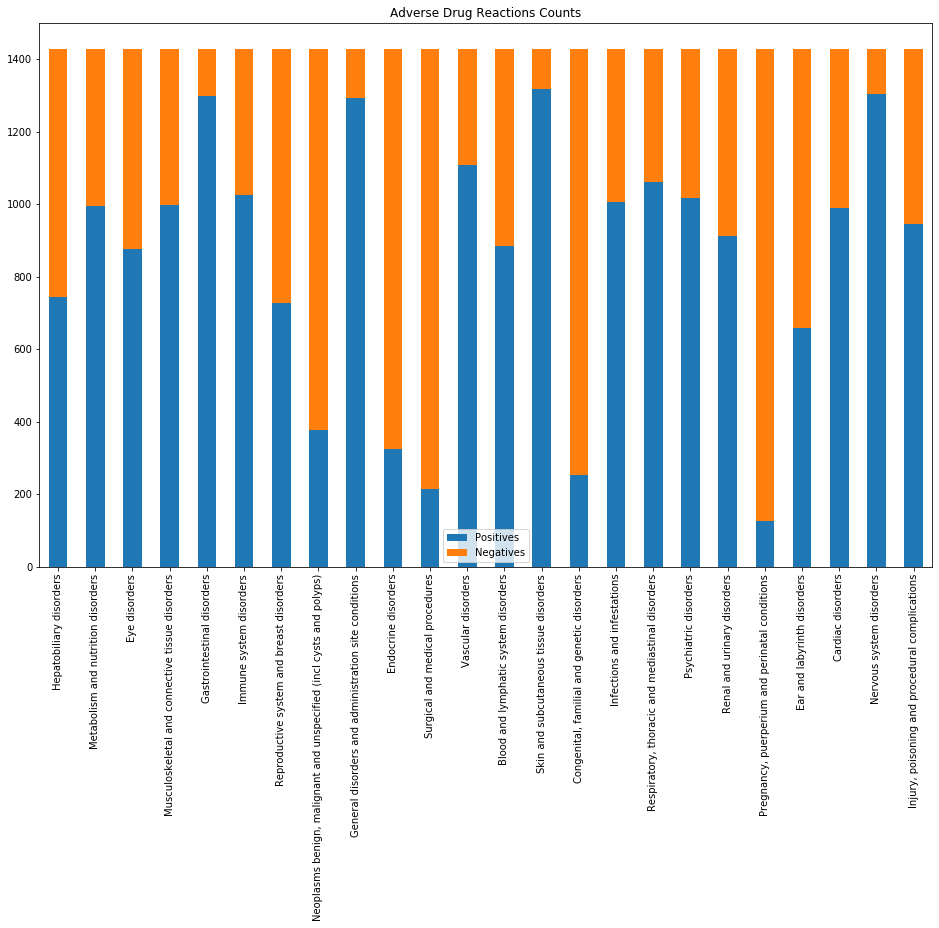

In [108]:
d = {"Positives": y_all.sum(axis=0), "Negatives": 1427 - y_all.sum(axis=0)}
countsm = pd.DataFrame(data=d)
countsm.plot(kind='bar', figsize=(16, 10), title="Adverse Drug Reactions Counts", ylim=(0, 1500), stacked=True)

# FEATURE GENERATION AND SELECTION

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [12:52<00:00, 38.62s/it]


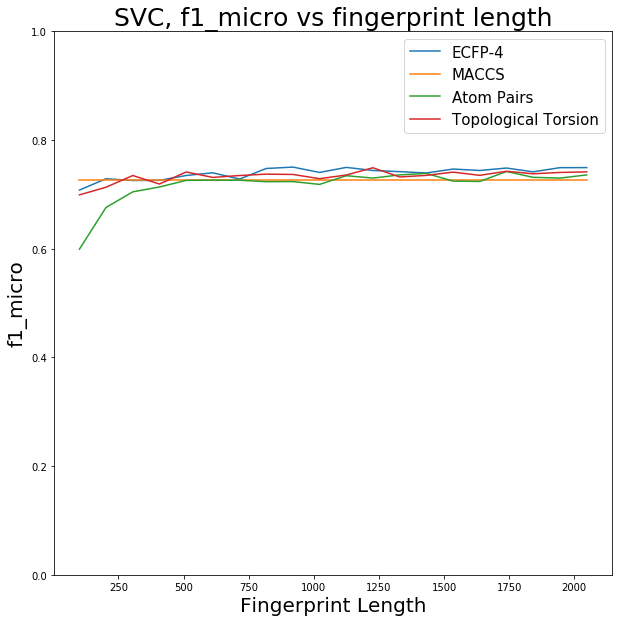

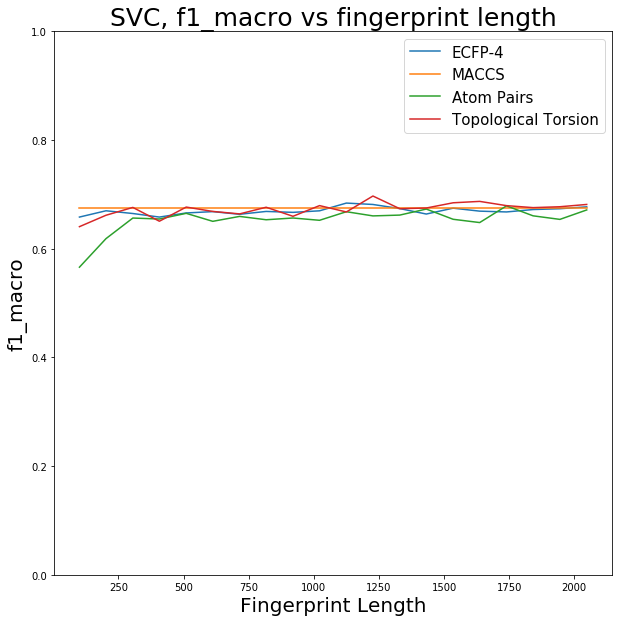

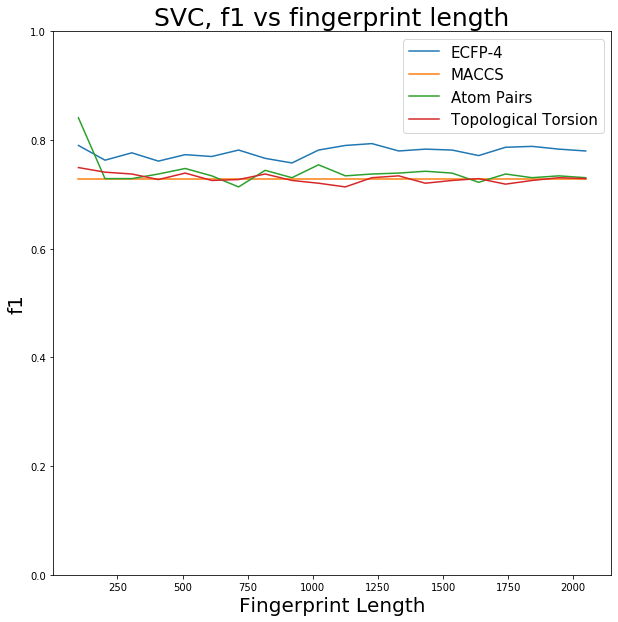

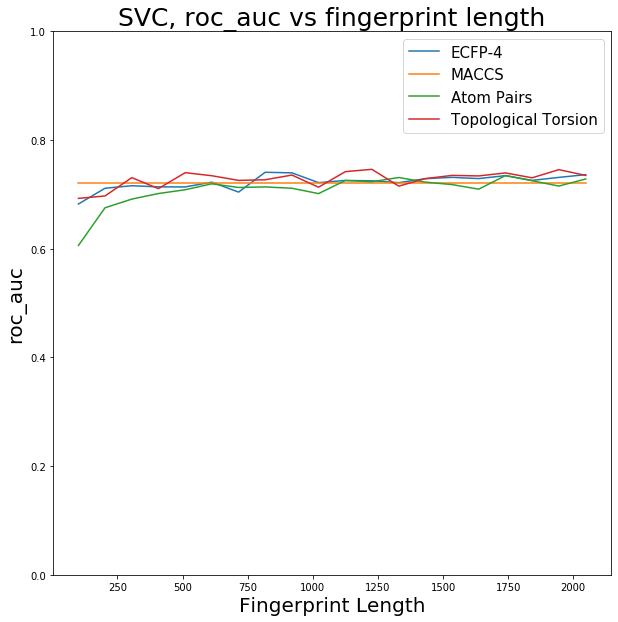

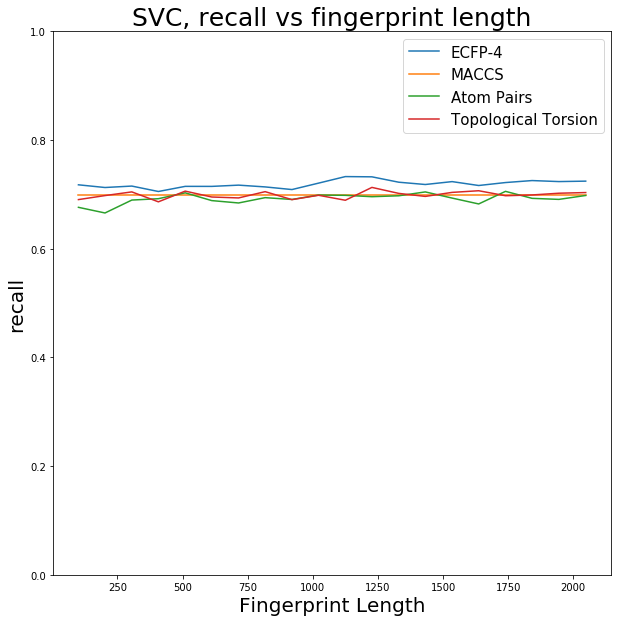

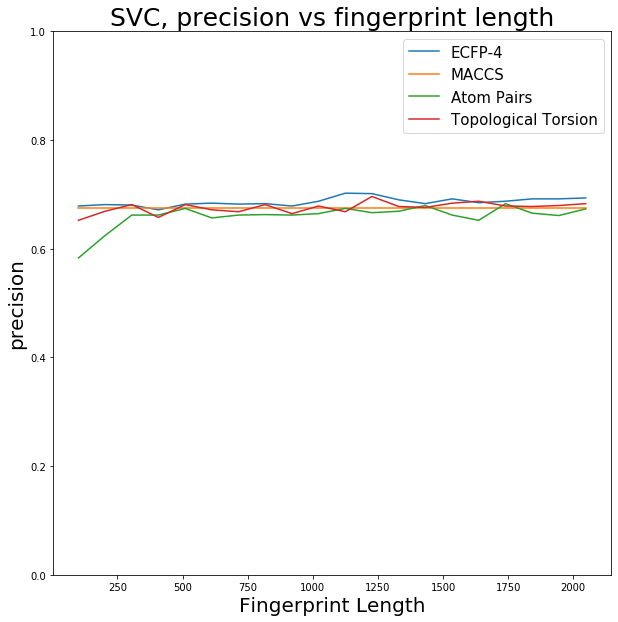

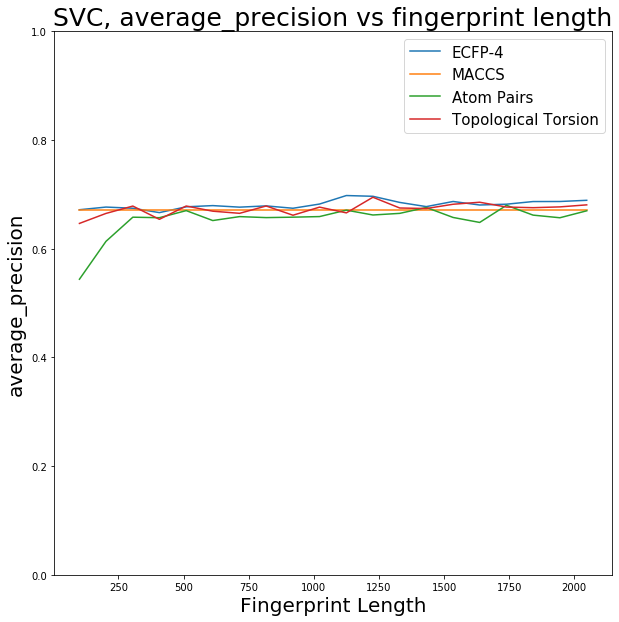

In [109]:
# fingerprint length
all_df_results_svc = test_fingerprint_size(df_mols_train, y_train, SVC(gamma="scale", random_state=seed), makeplots=True, write=False)
# Best result with ECFP-4 at 1125 - This will be used to all results

In [115]:
# Create X datasets with fingerprint length
X_all, _, _, _ = createfingerprints(df_molecules, length=1125)
X_train_fp, _, _, _ = createfingerprints(df_mols_train, length=1125)
X_test_fp, _, _, _ = createfingerprints(df_mols_test, length=1125)

# Selects and create descriptors dataset
df_desc = createdescriptors(df_molecules)  # Create all descriptors

# Splits in train and test
df_desc_base_train, df_desc_base_test = train_test_split(df_desc, test_size=0.2, random_state=seed)

# Creates a dictionary with key = class label and value = dataframe with fingerprint + best K descriptors for that label
X_train_dic, X_test_dic, selected_cols = create_dataframes_dic(df_desc_base_train, df_desc_base_test, X_train_fp,
                                                               X_test_fp, y_train, out_names, score_func=f_classif, k=3)
# Creates a y dictionary for all labels
y_train_dic = {name: y_train[name] for name in out_names}
modelnamesvc = {name: "SVC" for name in out_names}
modelnamerf = {name: "RF" for name in out_names}
modelnamexgb = {name: "XGB" for name in out_names}
modelnamevot = {name: "VotingClassifier" for name in out_names}

100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 130.97it/s]


In [116]:
print("Selected descriptors by label:")
pprint(selected_cols, width=-1)

Selected descriptors by label:
{'Blood and lymphatic system disorders': ['fracsp33',
                                          'aliphcarbocycles',
                                          'numsatcarbcycles'],
 'Cardiac disorders': ['arocarbocycles',
                       'arorings',
                       'numsatcarbcycles'],
 'Congenital, familial and genetic disorders': ['maxabspartcharge',
                                                'numrade',
                                                'arocarbocycles'],
 'Ear and labyrinth disorders': ['maxpartcharge',
                                 'aliphcarbocycles',
                                 'numsatcarbcycles'],
 'Endocrine disorders': ['numrade',
                         'aliphcarbocycles',
                         'numsatcarbcycles'],
 'Eye disorders': ['nhohcount',
                   'numhdonors',
                   'numhatoms'],
 'Gastrointestinal disorders': ['aliphcarbocycles',
                                'arorings'

The base RF model performed not only better than the base SVC model for most of the classification tasks, it also out-performed the optimized SVC model

# MODELING

In [112]:
# SVC MODEL DEVELOPMENT
print("SVC")
print("Base SVC without balancing:")
base_svc_report = cv_multi_report(X_train_dic, y_train, out_names, SVC(gamma="auto", random_state=seed), n_splits=5,
                                  n_jobs=-2, verbose=False)

SVC
Base SVC without balancing:


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:38<00:00,  4.09s/it]


In [113]:
print("Scores for SVC without balancing:")
base_svc_report

Scores for SVC without balancing:


,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,0.707,0.644,0.626,0.672,0.831,0.616,0.645
Metabolism and nutrition disorders,0.818,0.692,0.409,0.575,1.000,0.692,0.735
Eye disorders,0.763,0.622,0.418,0.613,0.990,0.620,0.701
Musculoskeletal and connective tissue disorders,0.815,0.687,0.407,0.636,1.000,0.687,0.788
Gastrointestinal disorders,0.951,0.907,0.476,0.683,1.000,0.907,0.947
Immune system disorders,0.841,0.726,0.421,0.597,1.000,0.726,0.803
Reproductive system and breast disorders,0.599,0.595,0.594,0.651,0.609,0.592,0.632
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.000,0.745,0.427,0.676,0.000,0.000,0.461
General disorders and administration site conditions,0.953,0.910,0.476,0.617,1.000,0.910,0.939
Endocrine disorders,0.000,0.786,0.440,0.637,0.000,0.000,0.396


In [114]:
print("Base SVC with balancing:")
base_bal_svc_report = cv_multi_report(X_train_dic, y_train, out_names, SVC(gamma="auto", random_state=seed), balancing=True, n_splits=5, n_jobs=-2, verbose=False, random_state=seed)

Base SVC with balancing:


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [29:40<00:00, 74.18s/it]


In [117]:
print("Scores for SVC with balancing:")
base_bal_svc_report

Scores for SVC with balancing:


,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,0.651,0.629,0.627,0.676,0.671,0.634,0.645
Metabolism and nutrition disorders,0.725,0.627,0.569,0.599,0.710,0.742,0.768
Eye disorders,0.710,0.618,0.574,0.616,0.766,0.663,0.700
Musculoskeletal and connective tissue disorders,0.737,0.645,0.593,0.634,0.727,0.750,0.777
Gastrointestinal disorders,0.908,0.838,0.608,0.722,0.884,0.934,0.956
Immune system disorders,0.793,0.684,0.564,0.600,0.833,0.757,0.790
Reproductive system and breast disorders,0.599,0.599,0.599,0.651,0.599,0.600,0.626
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.331,0.642,0.543,0.579,0.344,0.320,0.341
General disorders and administration site conditions,0.903,0.826,0.535,0.571,0.889,0.918,0.926
Endocrine disorders,0.280,0.702,0.546,0.560,0.274,0.290,0.284


In [118]:
diff_bal_svc = base_bal_svc_report - base_svc_report
print("Changes in scores after balancing:")
diff_bal_svc

Changes in scores after balancing:


,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,-0.056,-0.015,0.001,0.004,-0.160,0.018,0.000
Metabolism and nutrition disorders,-0.093,-0.065,0.160,0.024,-0.290,0.050,0.033
Eye disorders,-0.053,-0.004,0.156,0.003,-0.224,0.043,-0.001
Musculoskeletal and connective tissue disorders,-0.078,-0.042,0.186,-0.002,-0.273,0.063,-0.011
Gastrointestinal disorders,-0.043,-0.069,0.132,0.039,-0.116,0.027,0.009
Immune system disorders,-0.048,-0.042,0.143,0.003,-0.167,0.031,-0.013
Reproductive system and breast disorders,0.000,0.004,0.005,0.000,-0.010,0.008,-0.006
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.331,-0.103,0.116,-0.097,0.344,0.320,-0.120
General disorders and administration site conditions,-0.050,-0.084,0.059,-0.046,-0.111,0.008,-0.013
Endocrine disorders,0.280,-0.084,0.106,-0.077,0.274,0.290,-0.112


In [119]:
# Searching best parameters
params_to_test = {"svc__kernel": ["rbf"], "svc__C": [0.01, 0.1, 1, 10],
                  "svc__gamma": [0.001, 0.01, 0.1, 1]}
d_params_to_test = {name: params_to_test for name in out_names}

pprint(best_SVC_params_by_label, width=-1)

{'Blood and lymphatic system disorders': {'svc__C': 10,
                                          'svc__gamma': 0.01,
                                          'svc__kernel': 'rbf'},
 'Cardiac disorders': {'svc__C': 10,
                       'svc__gamma': 0.1,
                       'svc__kernel': 'rbf'},
 'Congenital, familial and genetic disorders': {'svc__C': 0.01,
                                                'svc__gamma': 1,
                                                'svc__kernel': 'rbf'},
 'Ear and labyrinth disorders': {'svc__C': 10,
                                 'svc__gamma': 0.01,
                                 'svc__kernel': 'rbf'},
 'Endocrine disorders': {'svc__C': 0.01,
                         'svc__gamma': 1,
                         'svc__kernel': 'rbf'},
 'Eye disorders': {'svc__C': 10,
                   'svc__gamma': 0.1,
                   'svc__kernel': 'rbf'},
 'Gastrointestinal disorders': {'svc__C': 0.01,
                                'svc__gamma'

In [120]:
print("Improved SVC with balancing:")
impr_bal_svc_report = cv_multi_report(X_train_dic, y_train, out_names, modelname=modelnamesvc, spec_params=best_SVC_params_by_label, balancing=True, n_splits=5, n_jobs=-2, verbose=False, random_state=seed)

Improved SVC with balancing:


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [36:45<00:00, 91.89s/it]


In [121]:
print("Scores for optimized SVC with balancing:")
impr_bal_svc_report

Scores for optimized SVC with balancing:


,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,0.706,0.678,0.675,0.733,0.746,0.671,0.710
Metabolism and nutrition disorders,0.810,0.695,0.515,0.613,0.942,0.711,0.773
Eye disorders,0.756,0.641,0.535,0.637,0.910,0.647,0.725
Musculoskeletal and connective tissue disorders,0.808,0.698,0.551,0.664,0.924,0.718,0.800
Gastrointestinal disorders,0.951,0.907,0.476,0.642,1.000,0.907,0.932
Immune system disorders,0.842,0.738,0.541,0.631,0.959,0.750,0.804
Reproductive system and breast disorders,0.659,0.660,0.660,0.723,0.655,0.663,0.725
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.000,0.745,0.427,0.672,0.000,0.000,0.369
General disorders and administration site conditions,0.953,0.910,0.476,0.600,1.000,0.910,0.930
Endocrine disorders,0.000,0.786,0.440,0.570,0.000,0.000,0.263


In [122]:
# Random Forest
print("Random Forest")
print("Base RF without balancing:")
base_rf_report = cv_multi_report(X_train_dic, y_train, out_names, RandomForestClassifier(n_estimators=100, random_state=seed), n_splits=5, n_jobs=-2, verbose=False)

Random Forest
Base RF without balancing:


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:26<00:00,  1.11s/it]


In [123]:
print("Scores for RF without balancing:")
base_rf_report

Scores for RF without balancing:


,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,0.706,0.685,0.684,0.737,0.731,0.683,0.729
Metabolism and nutrition disorders,0.808,0.699,0.555,0.604,0.913,0.724,0.756
Eye disorders,0.748,0.663,0.620,0.672,0.814,0.692,0.743
Musculoskeletal and connective tissue disorders,0.806,0.703,0.583,0.665,0.901,0.730,0.805
Gastrointestinal disorders,0.951,0.907,0.574,0.736,0.987,0.917,0.953
Immune system disorders,0.824,0.714,0.529,0.630,0.924,0.744,0.810
Reproductive system and breast disorders,0.646,0.646,0.645,0.726,0.648,0.647,0.738
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.306,0.766,0.583,0.727,0.203,0.632,0.509
General disorders and administration site conditions,0.948,0.902,0.513,0.601,0.987,0.913,0.932
Endocrine disorders,0.242,0.781,0.557,0.662,0.164,0.467,0.393


In [124]:
print("Base RF with balancing:")
base_bal_rf_report = cv_multi_report(X_train_dic, y_train, out_names, RandomForestClassifier(n_estimators=100, random_state=seed), balancing=True, n_splits=5, n_jobs=-2, verbose=False, random_state=seed)

Base RF with balancing:


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [26:26<00:00, 66.11s/it]


In [125]:
print("Scores for RF with balancing:")
base_bal_rf_report

Scores for RF with balancing:


,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,0.706,0.690,0.688,0.752,0.720,0.694,0.731
Metabolism and nutrition disorders,0.784,0.682,0.586,0.627,0.838,0.738,0.782
Eye disorders,0.738,0.659,0.624,0.670,0.784,0.698,0.739
Musculoskeletal and connective tissue disorders,0.779,0.681,0.601,0.675,0.819,0.743,0.809
Gastrointestinal disorders,0.941,0.891,0.627,0.737,0.956,0.927,0.952
Immune system disorders,0.803,0.698,0.575,0.646,0.850,0.761,0.819
Reproductive system and breast disorders,0.669,0.667,0.667,0.737,0.672,0.666,0.735
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.411,0.762,0.631,0.722,0.326,0.559,0.457
General disorders and administration site conditions,0.941,0.890,0.556,0.646,0.965,0.918,0.941
Endocrine disorders,0.274,0.764,0.566,0.657,0.213,0.413,0.362


In [126]:
# Searching best parameters
n_estimators = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
max_features = ["log2", "sqrt"]
max_depth = [50, 90, 130, 170, 210, 250]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2]
bootstrap = [True, False]
rf_grid = {"randomforestclassifier__n_estimators": n_estimators,
           "randomforestclassifier__max_features": max_features,
           "randomforestclassifier__max_depth": max_depth,
           "randomforestclassifier__min_samples_split": min_samples_split,
           "randomforestclassifier__min_samples_leaf": min_samples_leaf,
           "randomforestclassifier__bootstrap": bootstrap}
rf_grid_label = {name: rf_grid for name in out_names}

pprint(best_RF_params_by_label, width=-1)

{'Blood and lymphatic system disorders': {'randomforestclassifier__bootstrap': False,
                                          'randomforestclassifier__max_depth': 50,
                                          'randomforestclassifier__max_features': 'log2',
                                          'randomforestclassifier__min_samples_leaf': 2,
                                          'randomforestclassifier__min_samples_split': 10,
                                          'randomforestclassifier__n_estimators': 600},
 'Cardiac disorders': {'randomforestclassifier__bootstrap': False,
                       'randomforestclassifier__max_depth': 210,
                       'randomforestclassifier__max_features': 'sqrt',
                       'randomforestclassifier__min_samples_leaf': 1,
                       'randomforestclassifier__min_samples_split': 5,
                       'randomforestclassifier__n_estimators': 700},
 'Congenital, familial and genetic disorders': {'randomfores

In [127]:
print("Improved RF with balancing:")
impr_bal_rf_report = cv_multi_report(X_train_dic, y_train, out_names, modelname=modelnamerf,
                                     spec_params=best_RF_params_by_label, balancing=True, n_splits=5, n_jobs=-2,
                                     verbose=False, random_state=seed)

Improved RF with balancing:


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [27:46<00:00, 69.46s/it]


In [128]:
print("Scores for optimized RF with balancing:")
impr_bal_rf_report

Scores for optimized RF with balancing:


,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,0.722,0.703,0.701,0.757,0.746,0.702,0.739
Metabolism and nutrition disorders,0.789,0.684,0.577,0.628,0.856,0.733,0.782
Eye disorders,0.756,0.672,0.629,0.676,0.827,0.696,0.752
Musculoskeletal and connective tissue disorders,0.794,0.693,0.595,0.687,0.861,0.737,0.823
Gastrointestinal disorders,0.946,0.900,0.619,0.749,0.970,0.924,0.958
Immune system disorders,0.814,0.708,0.564,0.650,0.883,0.756,0.825
Reproductive system and breast disorders,0.671,0.668,0.668,0.740,0.678,0.665,0.752
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.404,0.770,0.631,0.738,0.306,0.600,0.480
General disorders and administration site conditions,0.941,0.890,0.569,0.668,0.963,0.920,0.947
Endocrine disorders,0.280,0.774,0.573,0.663,0.209,0.451,0.376
